In [1]:
import sys
sys.path.insert(0, '/Users/user/Documents/ecg_research/')

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.externals import joblib as jl
from savvyecg import ecg_utils as ecg_util
%matplotlib inline


In [28]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import wfdb as wf
import scipy.signal as ss
from sklearn.externals import joblib as jl
from biosppy.signals import ecg as ecgsig
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import peakutils as pu
from sklearn.metrics import confusion_matrix as cf
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from itertools import cycle

In [6]:
path_arr = '/Users/user/physionet.org/physiobank/database/ltafdb/'

In [7]:
patient = '01'
records = 'RECORDS'
records_arr = np.loadtxt(path_arr + records, 'str')
records_arr = np.array([i[2:4] for i in records_arr])

In [8]:
records_arr

array(['00', '01', '03', '05', '06', '07', '08', '10', '10', '10', '10',
       '10', '10', '10', '11', '11', '11', '11', '11', '11', '11', '11',
       '11', '11', '11', '12', '12', '12', '12', '13', '15', '16', '17',
       '18', '19', '20', '20', '20', '20', '20', '20', '20', '20', '20',
       '20', '21', '22', '23', '24', '25', '26', '28', '30', '32', '33',
       '34', '35', '37', '38', '39', '42', '43', '44', '45', '47', '48',
       '49', '51', '53', '54', '55', '56', '58', '60', '62', '64', '65',
       '68', '69', '70', '71', '72', '74', '75'], 
      dtype='<U2')

In [9]:
records_arr.shape

(84,)

In [10]:
f = 128 #Hz
window = int(0.4 * f) #second half-window

In [25]:
def show_confusion_matrix(C,class_labels=['0','1']):
    """
    C: ndarray, shape (2,2) as given by scikit-learn confusion_matrix function
    class_labels: list of strings, default simply labels 0 and 1.

    Draws confusion matrix with associated metrics.
    """
#     import matplotlib.pyplot as plt
#     import numpy as np
    
    assert C.shape == (2,2), "Confusion matrix should be from binary classification only."
    
    # true negative, false positive, etc...
    tn = C[0,0]; fp = C[0,1]; fn = C[1,0]; tp = C[1,1];

    NP = fn+tp # Num positive examples
    NN = tn+fp # Num negative examples
    N  = NP+NN

    fig = plt.figure(figsize=(8,8))
    ax  = fig.add_subplot(111)
    ax.imshow(C, interpolation='nearest', cmap=plt.cm.gray)

    # Draw the grid boxes
    ax.set_xlim(-0.5,2.5)
    ax.set_ylim(3.5,-0.5)
    ax.plot([-0.5,2.5],[0.5,0.5], '-k', lw=2)
    ax.plot([-0.5,2.5],[1.5,1.5], '-k', lw=2)
    ax.plot([-0.5,2.5],[2.5,2.5], '-k', lw=2)
    ax.plot([0.5,0.5],[-0.5,2.5], '-k', lw=2)
    ax.plot([1.5,1.5],[-0.5,2.5], '-k', lw=2)
    ax.plot([3.5,3.5],[-0.5,2.5], '-k', lw=2)
    
#     ax.plot([1.5,1.5],[-0.5,2.5], '-k', lw=2)
    # Set xlabels
    ax.set_xlabel('Predicted Label', fontsize=16)
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(class_labels + [''])
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    # These coordinate might require some tinkering. Ditto for y, below.
    ax.xaxis.set_label_coords(0.34,1.06)

    # Set ylabels
    ax.set_ylabel('True Label', fontsize=16, rotation=90)
    ax.set_yticklabels(class_labels + [''],rotation=90)
    ax.set_yticks([0,1,2])
    ax.yaxis.set_label_coords(-0.09,0.65)


    # Fill in initial metrics: tp, tn, etc...
    ax.text(0,0,
            'True Neg: %d\n(Num Neg: %d)'%(tn,NN),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,1,
            'False Neg: %d'%fn,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,0,
            'False Pos: %d'%fp,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    ax.text(1,1,
            'True Pos: %d\n(Num Pos: %d)'%(tp,NP),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    # Fill in secondary metrics: accuracy, true pos rate, etc...
    ax.text(2,0,
            'False Pos Rate: %.2f'%(fp / (fp+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,1,
            'True Pos Rate: %.2f'%(tp / (tp+fn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,2,
            'Accuracy: %.2f'%((tp+tn+0.)/N),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,2,
            'Neg Pred Val: %.2f'%(1-fn/(fn+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,2,
            'Pos Pred Val: %.2f'%(tp/(tp+fp+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))
    ax.text(0,3,
            'Sensitivity: %.2f'%(tp*1./(tp+fn)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))
    ax.text(1,3,
            'Specificity: %.2f'%(tn*1./(fp+tn)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    plt.tight_layout()
    plt.show()
    print (tp*1./(tp+fn), tn*1./(fp+tn))

# Curating/Separating AF from Non-AF

In [11]:
af_list, n_list = [], []
patient_dict = {}
for i in records_arr:
    pat = i
    sig, fields = wf.rdsamp(path_arr + i)
    ann_temp = wf.rdann(path_arr + i, 'qrs')
    arr_ann = np.array(ann_temp[1])
    arr_idx = np.array(ann_temp[0])
    ecg = sig[:,0]
    ecg_idx = np.linspace(0, ecg.shape[0], ecg.shape[0])
    if 'T' in arr_ann:
        arr_ann[np.where(arr_ann == 'N')] = 0
        arr_ann[np.where(arr_ann == 'T')] = 1
        T_idx = arr_idx[np.where(arr_ann == '1')][0]
#         AF_idx = np.where(ecg_idx < T_idx)
#         N_idx = np.where(ecg_idx > T_idx)
        af_peak_idx = arr_idx[np.where(arr_idx < T_idx)]
        n_peak_idx = arr_idx[np.where(arr_idx > T_idx)]
        af = np.array([ecg[i - window: i + window] for i in af_peak_idx[100:-100]])
        n = np.array([ecg[i - window: i + window] for i in n_peak_idx[100:-100]])
        num_af, _ = af.shape
        num_n, _ = n.shape
        num_samples = 10000
        if num_af > num_samples and num_n > num_samples:
        
            af_list.append(af[:num_samples])
            n_list.append(n[:num_samples])
        else:
            af_list.append(af)
            n_list.append(n)
            patient_dict[pat] = ecg
            print (pat)
            
        


06
38
42
72


In [12]:
af_arr = np.concatenate(af_list)
n_arr = np.concatenate(n_list)

In [20]:
# ltafdb_dict = {'AF':af_arr, 'N':n_arr}
# jl.dump(ltafdb_dict, '../ecg_research/Databases/AFIB_database.pickle')

In [13]:
print (af_arr.shape, n_arr.shape)

(278399, 102) (686224, 102)


In [14]:
af_label = np.array(['1']* af_arr.shape[0])
n_label = np.array(['0']* n_arr.shape[0])

In [15]:
X_ = np.concatenate([af_arr, n_arr])
y_ = np.concatenate([af_label, n_label])

In [16]:
pca = PCA(n_components=20)
X_new_ = pca.fit_transform(X_)

In [17]:
X_new_.shape

(964623, 20)

In [18]:
# X_c = StandardScaler().fit_transform(X_new)
X_train, X_test, y_train, y_test = train_test_split(X_new_, y_, test_size=.4, random_state=42)
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

In [20]:
best_classifier = MLPClassifier((100, 100, 100))
best_classifier.fit(X_train, y_train)
score = best_classifier.score(X_test, y_test)

In [21]:
pred_afib = best_classifier.predict(X_test)

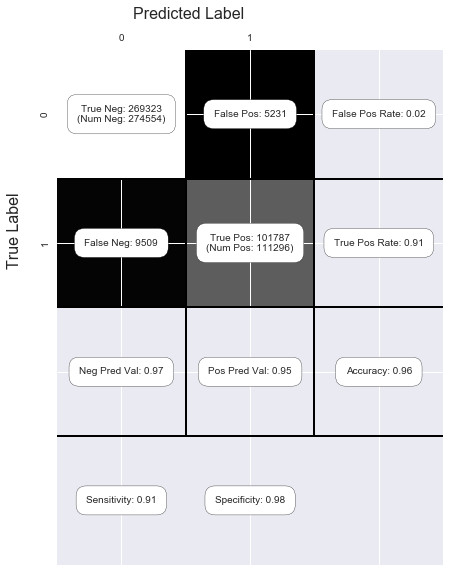

0.914561170213 0.980947281773


In [26]:
show_confusion_matrix(cf(y_test, pred_afib))

# Precision - Recall

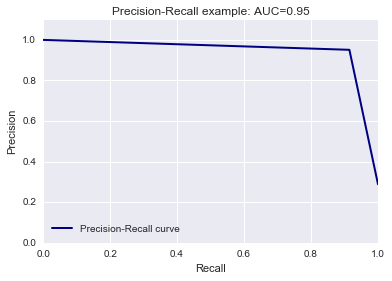

In [47]:
#plot details
# setup plot details
# colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])
n_classes = 1
colors = cycle(['turquoise', 'darkorange', 'cornflowerblue', 'teal'])
lw = 2
y_score = pred_afib
# y_test = gt
# y_test = y_test[:,[1,2,3]]
# y_score = prediction[:,[1,2,3]]


# Compute Precision-Recall and plot curve
# precision = 
# recall = dict()
# average_precision = dict()

precision, recall, _ = precision_recall_curve(y_test.astype('float'), y_score.astype('float'))
average_precision = average_precision_score(y_test.astype('float'), y_score.astype('float'))

# # Compute micro-average ROC curve and ROC area
# precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(),
#     y_score.ravel())
# average_precision["micro"] = average_precision_score(y_test, y_score,
#                                                      average="micro")


# Plot Precision-Recall curve
plt.clf()
plt.plot(recall, precision, lw=lw, color='navy',
         label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.1])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall example: AUC={0:0.2f}'.format(average_precision))
plt.legend(loc="lower left")
plt.show()

# # Plot Precision-Recall curve for each class
# plt.clf()
# plt.plot(recall["micro"], precision["micro"], color='gold', lw=lw,
#          label='micro-average Precision-recall curve (area = {0:0.2f})'
#                ''.format(average_precision["micro"]))
# list_names = ['PAC', 'BBBB', 'PVC']
# for i, color in zip(range(n_classes-1), colors):
#     plt.plot(recall[i], precision[i], color=color, lw=lw,
#              label='Precision-recall curve of class {0} (area = {1:0.2f})'
#                    ''.format(list_names[i], average_precision[i]))

# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.1])
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.title('Extension of Precision-Recall curve to multi-class')
# plt.legend(loc="lower right")
# plt.show()

In [43]:
help(precision_recall_curve)

Help on function precision_recall_curve in module sklearn.metrics.ranking:

precision_recall_curve(y_true, probas_pred, pos_label=None, sample_weight=None)
    Compute precision-recall pairs for different probability thresholds
    
    Note: this implementation is restricted to the binary classification task.
    
    The precision is the ratio ``tp / (tp + fp)`` where ``tp`` is the number of
    true positives and ``fp`` the number of false positives. The precision is
    intuitively the ability of the classifier not to label as positive a sample
    that is negative.
    
    The recall is the ratio ``tp / (tp + fn)`` where ``tp`` is the number of
    true positives and ``fn`` the number of false negatives. The recall is
    intuitively the ability of the classifier to find all the positive samples.
    
    The last precision and recall values are 1. and 0. respectively and do not
    have a corresponding threshold.  This ensures that the graph starts on the
    x axis.
    
    Re

In [40]:
y_test

array(['0', '0', '0', ..., '1', '0', '0'], 
      dtype='<U1')

# Test on Specific Patient

In [29]:
afib_patient_dict = jl.load('/Users/user/Documents/ecg_research/Databases/AFIB_patients.pickle')

In [46]:
afib_patient_test = afib_patient_dict[b'06'][60000:120000]

In [47]:
f = 120
ecg = afib_patient_test
window = int(f * 0.4) #800ms beat
ecg_new = ecg_util.baseline_correct(ecg, f)
rpeaks = np.array(ecgsig.hamilton_segmenter(ecg_new, f)['rpeaks'])[2:-2] #detect rpeaks from ecg
beats = np.array([ecg_new[i - window: i + window] for i in rpeaks])
pca = PCA(n_components=20)
beats_new = pca.fit_transform(beats)

In [48]:
pred_pat = best_classifier.predict(beats_new)

### Predicted as Normal Beat

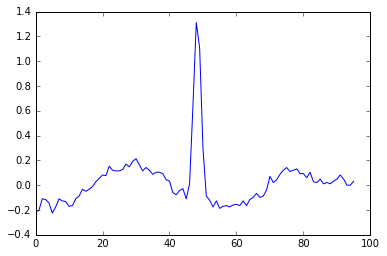

In [49]:
plt.plot(beats[np.where(pred_pat == '0')[0][0]])

### Predicted as Afib Beat

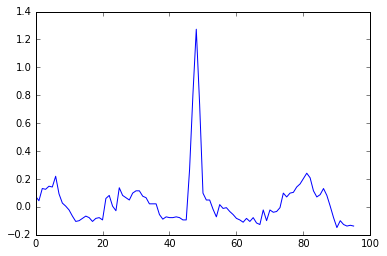

In [50]:
plt.plot(beats[np.where(pred_pat == '1')[0][0]])